In [1]:
#Some code has been modeled based on CISCO's Joy. 

In [2]:
import numpy as np
import pymongo
#from sklearn import neural_network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
import sys
import math
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import preprocessing
import matplotlib.pyplot as plt
from operator import add

In [3]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = client["flowdb"]
p_train_coll = mydb["trainP"]
p_test_coll = mydb["testP"]
b_train_coll = mydb["b2"]
b_test_coll = mydb["testB"]
net_train_coll = mydb["Netflow"]

In [4]:
p_train = []
p_test = []
b_train = []
b_test = []
p_train_l = []
p_test_l = []
b_train_l = []
b_test_l = []


In [5]:
#these are for the individualPL 
numRows = 10
binSize = 150.0

b_byte_dist_h = [0] * 256
b_ipt_h = np.zeros((numRows, numRows))
p_byte_dist_h = [0] * 256
p_ipt_h = np.zeros((numRows, numRows))
b_pl = np.zeros((numRows,numRows))
p_pl = np.zeros((numRows,numRows))

In [6]:
#def adjust_threshold()

## methods to gather data from flow

In [7]:
def getBD(doc, flag):
    data = []
    if len(doc['packets']) == 0:
        return np.zeros(256)
    if doc['byte_dist'] != None and sum(doc['byte_dist']) > 0:
        tmp = map(lambda x: x / float(sum(doc['byte_dist'])), doc['byte_dist'])
        data.extend(tmp)
        if flag == 0:
            for i in range(len(tmp)):
                b_byte_dist_h[i] += tmp[i]
        elif flag == 1:
            for i in range(len(tmp)):
                p_byte_dist_h[i] += tmp[i]
    else:
        data.extend(np.zeros(256))
    return data

In [8]:
def getIndividualPL(flow, flag):
    transMat = np.zeros((numRows, numRows))
    if len(flow['packets']) == 0:
        return
    elif len(flow['packets']) == 1:
        curPacketSize = min(int(flow['packets'][0]['b'] / binSize), numRows - 1)
        transMat[curPacketSize, curPacketSize] = 1
        if (flag == 0):
            b_pl[curPacketSize, curPacketSize] += 1
        elif (flag == 1):
            p_pl[curPacketSize, curPacketSize] += 1
        
        return (list(transMat.flatten()))
        

    # get raw transition counts
    for i in range(1, len(flow['packets'])):
        prevPacketSize = min(int(flow['packets'][i - 1]['b'] / binSize), numRows - 1)
        if 'b' not in flow['packets'][i]:
            break
        curPacketSize = min(int(flow['packets'][i]['b'] / binSize), numRows - 1)
        transMat[prevPacketSize, curPacketSize] += 1
        
        if (flag == 0):
            b_pl[prevPacketSize, curPacketSize] += 1
        elif (flag == 1):
            p_pl[prevPacketSize, curPacketSize] += 1
        
    # get empirical transition probabilities
    for i in range(numRows):
        if float(np.sum(transMat[i:i + 1])) != 0:
            transMat[i:i + 1] = transMat[i:i + 1] / float(np.sum(transMat[i:i + 1]))

    return (list(transMat.flatten()))

In [9]:
def getIPT(flow, flag):
    #numRows = 10
    binSize = 50.0
    transMat = np.zeros((numRows, numRows))
    if len(flow['packets']) == 0:
        return
    elif len(flow['packets']) == 1:
        curIPT = min(int(flow['packets'][0]['ipt'] / float(binSize)), numRows - 1)
        transMat[curIPT, curIPT] = 1
        
        #for updating histograms/box charts
        if (flag == 0):
            b_ipt_h[curIPT, curIPT] += 1
        elif (flag == 1):
            p_ipt_h[curIPT, curIPT] += 1
        return (list(transMat.flatten()))
        

    # get raw transition counts
    for i in range(1, len(flow['packets'])):
        prevIPT = min(int(flow['packets'][i - 1]['ipt'] / float(binSize)), numRows - 1)
        curIPT = min(int(flow['packets'][i]['ipt'] / float(binSize)), numRows - 1)
        transMat[prevIPT, curIPT] += 1
        
        if (flag == 0):
            b_ipt_h[prevIPT, curIPT] += 1
        elif (flag == 1):
            p_ipt_h[prevIPT, curIPT] += 1

    # get empirical transition probabilities
    for i in range(numRows):
        if float(np.sum(transMat[i:i + 1])) != 0:
            transMat[i:i + 1] = transMat[i:i + 1] / float(np.sum(transMat[i:i + 1]))

    return (list(transMat.flatten()))

In [10]:
def getMD(flow, flag):
    tmp = []

    if flow['dp'] != None:
        tmp.append(float(flow['dp']))  # destination port
    else:
        tmp.append(0)  # ICMP/etc.
    if flow['sp'] != None:
        tmp.append(float(flow['sp']))  # source port
    else:
        tmp.append(0)  # ICMP/etc.
    if 'num_pkts_in' in flow:
        tmp.append(flow['num_pkts_in'])  # inbound packets
    else:
        tmp.append(0)
    if 'num_pkts_out' in flow:
        tmp.append(flow['num_pkts_out'])  # outbound packets
    else:
        tmp.append(0)
    if 'bytes_in' in flow:
        tmp.append(flow['bytes_in'])  # inbound bytes
    else:
        tmp.append(0)
    if 'bytes_out' in flow:
        tmp.append(flow['bytes_out'])  # outbound bytes
    else:
        tmp.append(0)
    # elapsed time of flow
    if flow['packets'] == []:
        tmp.append(0)
    else:
        time = 0
        for packet in flow['packets']:
            time += packet['ipt']
        tmp.append(time)
    return tmp

## set up arrays using methods from above to be trained on

In [11]:
for doc in p_train_coll.find():
    tmpd = []
    tmp = getMD(doc, 1)
    tmpb = getBD(doc, 1)
    if (tmpb is None or len(tmpb) != 256):
        continue
    #tmpbd = preprocessing.scale(tmpb)
    tmpift = getIPT(doc, 1)
    
    #note: these 100's need to be changed if numRows is changed
    #if (tmpift is None or len(tmpift) != 100):
    #    continue
        
    tmpind_pl = getIndividualPL(doc, 1)
    #if (tmpind_pl is None or len(tmpind_pl) != 100):
    #    continue
    
    
    tmpd.extend(tmp)
    tmpd.extend(tmpb)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_fl)
    p_train.append(tmpd)
    p_train_l.append(1)

for doc in net_train_coll.find({'$or':[{'da': '192.168.5.113'}, {'sa': '192.168.5.113'}]}):
    tmpd = []
    tmp = getMD(doc, -1)
    tmpb = getBD(doc, -1)
    if (tmpb is None or len(tmpb) != 256):
        continue
    #tmpbd = preprocessing.scale(tmpb)
    tmpift = getIPT(doc, -1)
    
    #note: these 100's need to be changed if numRows is changed
    #if (tmpift is None or len(tmpift) != 100):
    #    continue
        
    tmpind_pl = getIndividualPL(doc, -1)
    #if (tmpind_pl is None or len(tmpind_pl) != 100):
    #    continue
    
    tmpd.extend(tmp)
    tmpd.extend(tmpb)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_fl)
    p_train.append(tmpd)
    p_train_l.append(1)


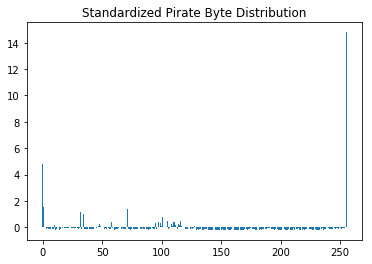

In [12]:
y_pos = np.arange(len(p_byte_dist_h))
x = preprocessing.scale(p_byte_dist_h)
plt.bar(y_pos, x)
plt.title("Standardized Pirate Byte Distribution")
plt.show()

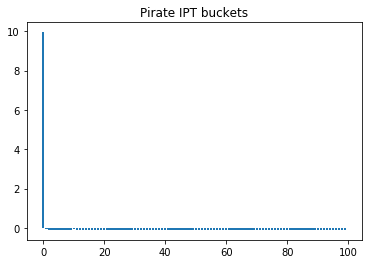

In [13]:
p_ipt_h = p_ipt_h.flatten()
y_pos = np.arange(len(p_ipt_h))
x = preprocessing.scale(p_ipt_h)
plt.bar(y_pos, x)
plt.title("Pirate IPT buckets")
plt.show()

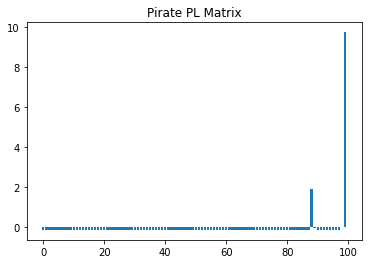

In [14]:
p_pl = p_pl.flatten()
y_pos = np.arange(len(p_pl))
x = preprocessing.scale(p_pl)
plt.bar(y_pos, x)
plt.title('Pirate PL Matrix')
plt.show()

In [15]:
for doc in p_test_coll.find():
    tmpd = []
    tmp = getMD(doc, -1)
    tmpb = getBD(doc, -1)
    if (tmpb is None or len(tmpb) != 256):
        continue
    #tmpbd = preprocessing.scale(tmpb)
    #tmpift = getIPT(doc, -1)
    
    #note: these 100's need to be changed if numRows is changed
    #if (tmpift is None or len(tmpift) != 100):
    #    continue
        
    #tmpind_pl = getIndividualPL(doc, -1)
    #if (tmpind_pl is None or len(tmpind_pl) != 100):
    #    continue
    
    tmpd.extend(tmp)
    tmpd.extend(tmpb)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_fl)
    p_test.append(tmpd)
    p_test_l.append(1)
    

In [16]:
for doc in b_train_coll.find():
    tmpd = []
    tmp = getMD(doc, 0)
    tmpb = getBD(doc, 0)
    if (tmpb is None or len(tmpb) != 256):
        continue
    #tmpbd = preprocessing.scale(tmpb)
    tmpift = getIPT(doc, 0)
    
    #note: these 100's need to be changed if numRows is changed
    #if (tmpift is None or len(tmpift) != 100):
    #    continue
        
    tmpind_pl = getIndividualPL(doc, 0)
    #if (tmpind_pl is None or len(tmpind_pl) != 100):
    #    continue
    
    tmpd.extend(tmp)
    tmpd.extend(tmpb)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_fl)
    b_train.append(tmpd)
    b_train_l.append(0)


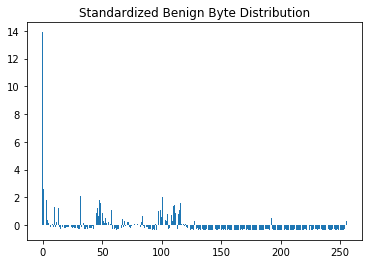

In [17]:
y_pos = np.arange(len(b_byte_dist_h))
x = preprocessing.scale(b_byte_dist_h)
plt.bar(y_pos, x)
plt.title("Standardized Benign Byte Distribution")
plt.show()

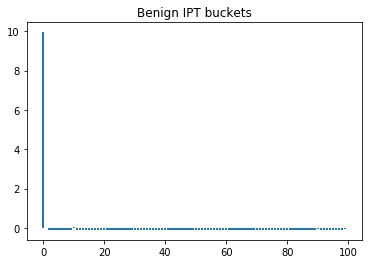

In [18]:
b_ipt_h = b_ipt_h.flatten()
y_pos = np.arange(len(b_ipt_h))
x = preprocessing.scale(b_ipt_h)
plt.bar(y_pos, x)
plt.title("Benign IPT buckets")
plt.show()

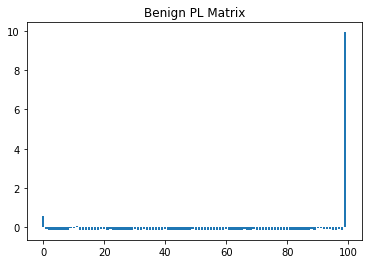

In [19]:
b_pl = b_pl.flatten()
y_pos = np.arange(len(b_pl))
x = preprocessing.scale(b_pl)
plt.bar(y_pos, x)
plt.title('Benign PL Matrix')
plt.show()

In [20]:
for doc in b_test_coll.find():
    tmpd = []
    tmp = getMD(doc, -1)
    tmpb = getBD(doc, -1)
    if (tmpb is None or len(tmpb) != 256):
        continue
    #tmpbd = preprocessing.scale(tmpb)
    #tmpift = getIPT(doc, -1)
    
    #note: these 100's need to be changed if numRows is changed
    #if (tmpift is None or len(tmpift) != 100):
    #    continue
        
    #tmpind_pl = getIndividualPL(doc, -1)
    #if (tmpind_pl is None or len(tmpind_pl) != 100):
    #    continue
    
    tmpd.extend(tmp)
    tmpd.extend(tmpb)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_fl)
    b_test.append(tmpd)
    b_test_l.append(0)
    

In [ ]:
training_set = []
training_set.extend(b_train)
training_set.extend(p_train)
training_labels = []
training_labels.extend(b_train_l)
training_labels.extend(p_train_l)
training_set = np.array(training_set)
training_labels = np.array(training_labels)
b_train = np.array(b_train)
p_train = np.array(p_train)
b_train_l = np.array(b_train_l)
p_train_l = np.array(p_train_l)

In [ ]:
test_set = []
test_labels = []
test_set.extend(b_test)
test_set.extend(p_test)
test_labels.extend(b_test_l)
test_labels.extend(p_test_l)
test_set = np.array(test_set)
test_labels = np.array(test_labels)
b_test = np.array(b_test)
p_test = np.array(p_test)
b_test_l = np.array(b_test_l)
p_test_l = np.array(p_test_l)

In [ ]:
logreg = LogisticRegression()
logreg.fit(training_set, training_labels)
print(logreg.score(test_set, test_labels))
print(logreg.score(b_test, b_test_l))
print(logreg.score(p_test, p_test_l))

In [ ]:
print(logreg.score(training_set, training_labels))

In [ ]:
'''neural_net = MLPClassifier()
neural_net.fit(training_set, training_labels)
print(neural_net.score(test_set, test_labels))
print(neural_net.score(b_test, b_test_l))
print(neural_net.score(p_test, p_test_l))'''

'''dtest = DecisionTreeClassifier()

params = {'max_leaf_nodes': range(10,200,30),
         'min_samples_leaf': range(5, 100, 25),
         'max_depth': range(5, 100, 25)}
gsearch = GridSearchCV(dtest, params, cv=5)
gsearch.fit(training_set, training_labels)
'''

In [ ]:
#print(gsearch.best_params_)
#print(gsearch.best_estimator_)

In [ ]:

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(training_set, training_labels)
print(dt.score(test_set, test_labels))
print(dt.score(b_test, b_test_l))
print(dt.score(p_test, p_test_l))

In [ ]:
dt = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=70, max_depth=30, min_samples_leaf=55)
dt.fit(training_set, training_labels)
print(dt.score(test_set, test_labels))
print(dt.score(b_test, b_test_l))
print(dt.score(p_test, p_test_l))

In [ ]:
print(dt.predict_proba(p_test))

In [ ]:
n_test_coll = mydb["netflow_test"]
n_test = []
n_l = []
for doc in n_test_coll.find({'$or':[{'da': '192.168.5.113'}, {'sa': '192.168.5.113'}]}):
    tmpd = []
    tmp = getMD(doc, -1)
    tmpb = getBD(doc, -1)
    if (tmpb is None or len(tmpb) != 256):
        continue
    #tmpbd = preprocessing.scale(tmpb)
    #tmpift = getIPT(doc, -1)
    
    #note: these 100's need to be changed if numRows is changed
    #if (tmpift is None or len(tmpift) != 100):
    #    continue
        
    #tmpind_pl = getIndividualPL(doc, -1)
    #if (tmpind_pl is None or len(tmpind_pl) != 100):
    #    continue
    
    tmpd.extend(tmp)
    tmpd.extend(tmpb)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_pl)
    n_test.append(tmpd)
    n_l.append(1)


In [ ]:
print(dt.score(n_test, n_l))

In [ ]:
probs = dt.predict_proba(n_test)
print (probs)


In [ ]:
'''j = 0
for i in range(len(probs)):
    if probs[i][1] == 1.:
        print(n_test[i])
        j +=1 
        
print j'''

In [ ]:
#print(neural_net.score(n_test, n_l))
#about comparing results between this and the joy output stuff. 

In [ ]:
#all benign test
ab_test_coll = mydb["bWeb"]
ab_test = []
ab_l = []
for doc in ab_test_coll.find():
    tmpd = []
    tmp = getMD(doc, -1)
    tmpb = getBD(doc, -1)
    if (tmpb is None or len(tmpb) != 256):
        continue
    #tmpbd = preprocessing.scale(tmpb)
    #tmpift = getIPT(doc, -1)
    
    #note: these 100's need to be changed if numRows is changed
    #if (tmpift is None or len(tmpift) != 100):
    #    continue
        
    #tmpind_pl = getIndividualPL(doc, -1)
    #if (tmpind_pl is None or len(tmpind_pl) != 100):
    #    continue
    
    tmpd.extend(tmp)
    tmpd.extend(tmpb)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_pl)
    ab_test.append(tmpd)
    ab_l.append(0)


In [ ]:
print(dt.score(ab_test, ab_l))

In [ ]:
print(dt.predict_proba(ab_test))